<a href="https://colab.research.google.com/github/wfreinhart/sdmm-regression/blob/main/notebooks/figure5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# make chart from precomputed data file

## load json

In [ ]:
import numpy as np
import json

with open('metrics-sequence-vector.json', 'r') as fid:
    metrics = json.load(fid)

## draw charts

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager
sc = 1.5
matplotlib.rcParams['font.family'] = 'Open Sans'  # the font name
matplotlib.rcParams['font.size'] = 9*sc                   # the font size
font_manager._rebuild()  # this is a hack to fix something in Google Colab

In [ ]:
def create_bar_chart(metrics, metric_key):
    # rearrange the data to easily compose the chart
    chart_labels = [k for k, v in metrics.items()]
    chart_data = {'train': [], 'test': []}
    for short_name, these_scores in metrics.items():
        this_dict = {key: [it[metric_key] for it in these_scores[key]] for key in ['train', 'test']}
        for key in ['train', 'test']:
            chart_data[key].append(this_dict[key])

    keys = metrics.keys()

    fig, ax = plt.subplots(figsize=(3.54*sc, 3.54*sc))
    for i, s in enumerate(['train', 'test']):
        if s == 'train':
            mf = 'none'
            h = '//'
            a = 1.0
        else:
            mf = 'tab:blue'
            h = ''
            a = 0.8
        mu = np.mean(chart_data[s], axis=1)
        sigma = np.std(chart_data[s], axis=1)
        ax.bar(np.arange(len(keys))+0.2*(2*i-1), mu, yerr=sigma, label=s, 
            facecolor=mf, alpha=a, hatch=h, 
            width=0.40, color='tab:blue', edgecolor='tab:blue', linewidth=1.5, capsize=4)
    ax.set_xticks(np.arange(len(keys)))
    short_keys = [key.split('.')[-1].split("'")[0].replace("Regressor", "").replace("Regression", "") for key in keys]
    j = np.argwhere([k == 'MLP' for k in short_keys])[0]
    short_keys[int(j)] = 'MLP-1'
    ax.set_xticklabels(short_keys, rotation=45, ha='right')
    ax.legend()
    if metric_key == 'rmse':
        ax.set_ylim(0, 5)
        ax.set_ylabel('RMSE')
    elif metric_key == 'rsq':
        ax.set_ylim(0, 1.01)
        ax.set_ylabel('$R^2$')
    fig.tight_layout()

    return fig

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


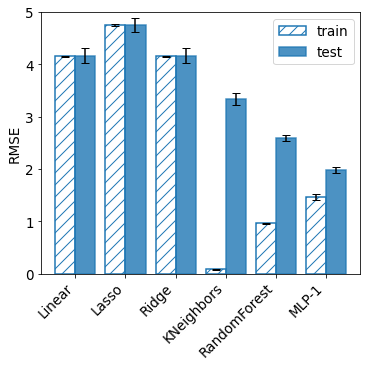

In [ ]:
fig = create_bar_chart(metrics, 'rmse')
fig.savefig('fig5a.pdf', bbox_inches='tight', pad_inches=0.05)

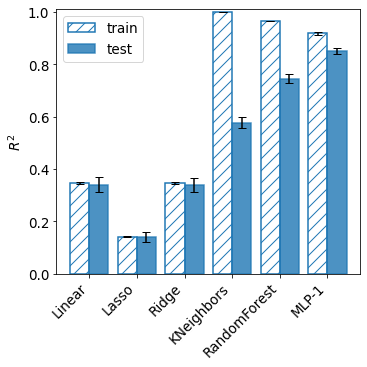

In [ ]:
fig = create_bar_chart(metrics, 'rsq')
fig.savefig('fig5b.pdf', bbox_inches='tight', pad_inches=0.05)

# create json data file

## load training data

In [ ]:
import numpy as np
import json

with open('data-10-folds.json', 'r') as fid:
    buffer = json.load(fid)

X = np.array(buffer['X'])
y = np.array(buffer['y'])

fold_data = []
for fold in buffer['folds']:
    train_index = np.array(fold['train'])
    test_index = np.array(fold['test'])

    trainX, testX = X[train_index], X[test_index]
    trainy, testy = y[train_index], y[test_index]
    
    fold_data.append({'train': {'X': trainX, 'y': trainy},
                      'test': {'X': testX, 'y': testy}
                      })

## train models

In [ ]:
from sklearn import linear_model
from sklearn import neighbors
from sklearn import ensemble
from sklearn import neural_network

models = [(linear_model.LinearRegression, dict()),
          (linear_model.Lasso, dict()),
          (linear_model.Ridge, dict()),
          # (neighbors.KNeighborsRegressor, dict(n_neighbors=15, weights='distance')),
          (neighbors.KNeighborsRegressor, dict()),
          (ensemble.RandomForestRegressor, dict(random_state=0)),
          (neural_network.MLPRegressor, dict(max_iter=2000, random_state=0)),
          ]

def train_model(model_def, this_data):

    constructor, params = model_def
    model = constructor(**params)

    this_X = this_data['train']['X']
    this_y = this_data['train']['y']

    train_X = np.vstack([this_X, np.fliplr(this_X)])
    train_y = np.vstack([this_y, this_y])

    model.fit(train_X, train_y)

    return model

trained_models = {}
for model_def in models:
    constructor, params = model_def
    short_name = str(constructor).split("'>")[0].split('.')[-1]
    these_models = []
    for i, this_data in enumerate(fold_data):
        model = train_model(model_def, this_data)
        these_models.append(model)    
    trained_models[short_name] = these_models

### save models

In [ ]:
import pickle

with open('models-sklearn-sequence-vector.pkl', 'wb') as fid:
    pickle.dump(trained_models, fid)

## test models

In [ ]:
def test_model(model, this_data):
    test_X = this_data['X']
    test_y = this_data['y']

    # forward sequences
    pred_z_fwd = model.predict(test_X)

    # reverse sequences
    pred_z_rev = model.predict(np.fliplr(test_X))

    # get residual from averarage of the two predictions
    residual = 0.5*(pred_z_fwd + pred_z_rev) - test_y

    # compute rmse from residual
    rmse_avg = np.sqrt(np.mean(residual**2))

    # compute Rsq from explained variance
    rsq = 1 - np.var(residual) / np.var(test_y)

    return {'rmse': rmse_avg, 'rsq': rsq}


metrics = {}
for short_name, these_models in trained_models.items():
    constructor, params = model_def
    metrics[short_name] = {}
    for key in ['test', 'train']:
        these_scores = []
        for i, this_data in enumerate(fold_data):
            model = these_models[i]
            score = test_model(model, this_data[key])
            these_scores.append(score)
        metrics[short_name][key] = these_scores

### look at results

In [ ]:
for short_name, these_scores in metrics.items():
    train, test = [[it['rmse'] for it in these_scores[key]] for key in ['train', 'test']]
    print(f'{short_name:25s} {np.mean(train):.3f} +/- {np.std(train):.3f} ; {np.mean(test):.3f} +/- {np.std(test):.3f}')

LinearRegression          4.154 +/- 0.016 ; 4.169 +/- 0.139
Lasso                     4.759 +/- 0.015 ; 4.759 +/- 0.134
Ridge                     4.153 +/- 0.015 ; 4.171 +/- 0.139
KNeighborsRegressor       0.087 +/- 0.011 ; 3.336 +/- 0.114
RandomForestRegressor     0.965 +/- 0.005 ; 2.592 +/- 0.058
MLPRegressor              1.468 +/- 0.058 ; 1.983 +/- 0.053


## save metrics to json

In [ ]:
import json

with open('metrics-sequence-vector.json', 'w') as fid:
    json.dump(metrics, fid)

## compute predictions on test data for all folds

In [ ]:
def get_predictions(model, this_data):

    test_X = this_data['test']['X']
    test_y = this_data['test']['y']

    # forward sequences
    pred_z_fwd = model.predict(test_X)

    # reverse sequences
    pred_z_rev = model.predict(np.fliplr(test_X))

    # get residual from averarage of the two predictions
    pred_z_avg = 0.5*(pred_z_fwd + pred_z_rev)

    return pred_z_avg


predictions = {}
for short_name, these_models in trained_models.items():
    constructor, params = model_def
    predictions[short_name] = []
    for i, this_data in enumerate(fold_data):
        model = these_models[i]
        out = get_predictions(model, this_data)
        predictions[short_name].append(out.tolist())

### save predictions to json

In [ ]:
import json

with open('predictions-sequence-vector.json', 'w') as fid:
    json.dump(predictions, fid)

In [ ]:
import os
import joblib

drive_prefix = 'drive/Shareddrives/Polymers-Data'
L = 8
all_evals = joblib.load(os.path.join(drive_prefix, 'models', f'metrics-L{L}.jbl'))